In [ ]:
#| default_exp prediction.ar
#| default_cls_lvl 3

In [ ]:
#| export
from tsfast.data import *
from tsfast.models import *
from tsfast.learner import *
# from tsfast.dataloaders import *
from fastai.basics import *
# from fastai.callback.schedule import *

In [ ]:
from nbdev.config import get_config

In [ ]:
project_root = get_config().config_file.parent
f_path = project_root / 'test_data/WienerHammerstein'

In [ ]:
hdf_files = get_hdf_files(f_path)
init_sz = 300
u = ['u']
y = ['y']
seq = DataBlock(blocks=(SequenceBlock.from_hdf(u+y,TensorSequencesInput,clm_shift=[0,-1]),
                        SequenceBlock.from_hdf(y,TensorSequencesOutput,clm_shift=[-1])),
                 get_items=CreateDict([DfHDFCreateWindows(win_sz=500+1,stp_sz=100,clm='u')]),
                 splitter=ApplyToDict(FuncSplitter(lambda o: 'valid' in str(o))))
db = seq.dataloaders(hdf_files,bs=32,dl_type=TfmdDL)

In [ ]:
db.one_batch()[0][0].shape,db.one_batch()[0][1].shape 

(torch.Size([500, 2]), torch.Size([500, 2]))

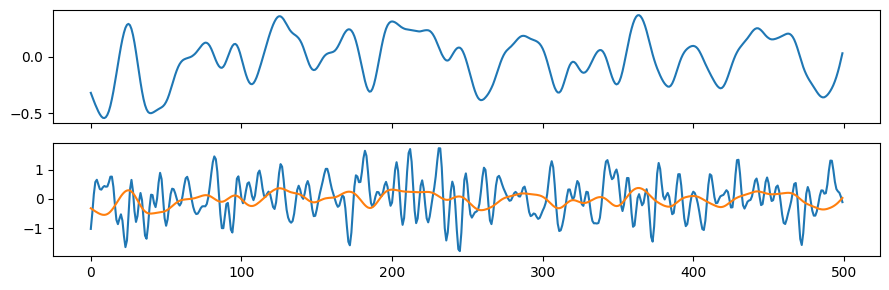

In [ ]:
db.show_batch(max_n=1)

## Autoregressive Prognosis

### Same RNN used for State Estimation and Prediction

In [ ]:
#| export
class ARProg(nn.Module):
    
    @delegates(RNN, keep=True)
    def __init__(self,n_u,n_x,n_y,init_sz,**kwargs):
        super().__init__()
        store_attr()

        #the output is n_x+n_y even if we output only n_y, because we need the output external states back into the model
        self.rnn_model = AR_Model(
            SimpleRNN(input_size=n_u+n_x+n_y,output_size=n_x+n_y,return_state=True,**kwargs),
            model_has_state=True,return_state=True,ar=True,out_sz=n_x+n_y
            )

    def forward(self, x):
        y_x = x[...,self.n_u:] #measured output and external state
        u = x[...,:self.n_u] #measured input

        out_init,h = self.rnn_model(u[:,:self.init_sz],y_x[:,:self.init_sz],ar=False)
        self.rnn_model.y_init = y_x[:,self.init_sz:self.init_sz+1]
        out_prog,_ = self.rnn_model(u[:,self.init_sz:],h_init=h,ar=True)

        result=torch.cat([out_init,out_prog],1) 

        return result[...,-self.n_y:]

In [ ]:
xb,yb = db.one_batch()
model = ARProg(len(u),0,len(y),init_sz=init_sz,num_layers=1,hidden_size=100).to(xb.device)
model(xb).shape

torch.Size([32, 500, 1])

In [ ]:
from fastai.callback.training import ShortEpochCallback

In [ ]:
model = ARProg(len(u),0,len(y),init_sz=init_sz,num_layers=1,hidden_size=50)
lrn = Learner(db,model,loss_func=SkipNLoss(mse,init_sz))
lrn.add_cb(TbpttResetCB())
lrn.add_cb(ShortEpochCallback())
#lrn.fit(1,lr=3e-3)
lrn.fit_flat_cos(1,3e-3,pct_start=0.2)

In [ ]:
#| include: false
import nbdev; nbdev.nbdev_export()